## Deep Researcher
### Using Orchestrator And Synthesizer
- given a topic creates a plan
  - i.e. sections
- for every section tools are available
  - search arxiv
  - search internet (tavilysearch)
- summarizes information
- checks if revision is required or more searches are required
- creates final summary

In [1]:
import os
import re
from dotenv import load_dotenv
import operator
import requests
from bs4 import BeautifulSoup

from pydantic import BaseModel, Field
from typing import List, Optional, Dict
from typing_extensions import Annotated, Literal, TypedDict

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.constants import Send
from langgraph.types import interrupt, Command
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import Tool
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# tools
from langchain_community.retrievers import WikipediaRetriever
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_community.retrievers import ArxivRetriever



from langgraph.checkpoint.memory import MemorySaver

from IPython.display import display, Markdown, Image

/run/media/kuldeepsingh/Work/venv_environments/ai_agents_experiments/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(".env")

False

In [3]:
class GoogleSearchExtractor:
    def __init__(self, api_key, cse_id, num_results=3, max_char_length=1000):
        self.google_search = GoogleSearchAPIWrapper(
            google_api_key=api_key,
            google_cse_id=cse_id,
            k=num_results
        )
        self.k = num_results
        self.max_char_length = max_char_length
    
    def clean_text(self, text):
        """Clean the text by removing newlines and tabs."""
        text = re.sub(r'[\n\t]+', ' ', text)
        return text

    def extract_html(self, url):
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            return self.clean_text(soup.get_text())[:self.max_char_length]
        return ""

    def search(self, query):
        search_results = self.google_search.results(query, self.k)
        print(len(search_results))
        extracted_results = []
        for result in search_results:
            print(result["title"])
            extracted_results.append({
                "title": result["title"],
                "content": self.extract_html(result["link"]),
                "url": result["link"]
            })
        return extracted_results

# google_search_extractor = GoogleSearchExtractor(
#     api_key=os.getenv("GOOGLE_API_KEY"),
#     cse_id=os.getenv("GOOGLE_CSE_ID"))

# results = google_search_extractor.search("Samsung company valuation")
# print(results)

def preprocess_long_text(text):
    """Preprocess long text by removing newlines and tabs."""
    # Remove newlines and tabs
    text = re.sub(r'[\n\t]+', ' ', text)
    
    # Truncate to 1000 characters
    if len(text) > 1000:
        text = text#[:1000]
    
    return text

# Convert TavilySearchResults into a tool
tavily_retriever = TavilySearchResults(
    api_key=os.environ["TAVILY_API_KEY"],
    max_results=2
)

def call_tavily_search(query: str) -> List[dict]:
    search_results = tavily_retriever.invoke(query)
    formatted_results = []
    for result in search_results:
        formatted_results.append(
            {   "search_query": query,
                "title": "",
                "source": result["url"],
                "content": preprocess_long_text(result["content"]),
                "search_engine": "Tavily"
            }
        )
    return formatted_results

search_tavily = Tool(
    name="search_tavily",
    description="Search Tavily for the given query. Best for real-time web search and retrieving structured, domain-specific information efficiently.",
    func=call_tavily_search
)


# Convert ArxivRetriever into a tool
arxiv_retriever = ArxivRetriever(
    load_max_docs=3
)
def call_arxiv_search(query:str) -> List[dict]:
    search_results = arxiv_retriever.invoke(query)
    formatted_results = []
    for result in search_results:
        formatted_results.append(
            {   "search_query": query,
                "title": result.metadata["Title"],
                "source": result.metadata["Entry ID"],
                "content": preprocess_long_text(result.page_content),
                "search_engine": "arXiv"
            }
        )
    return formatted_results
    
search_arxiv = Tool(
    name="search_arxiv",
    description="Search Arxiv for the given query. arXiv → Best for academic research, technical papers, and cutting-edge scientific studies in fields like ML, physics, and mathematics.",
    func=call_arxiv_search
)


# wikipedia tool
wikipedia_retriever = WikipediaRetriever(
    top_k_results=3
)
def call_wikipedia_search(query: str) -> List[dict]:
    search_results = wikipedia_retriever.invoke(query)
    formatted_results = []
    for result in search_results:
        formatted_results.append(
            {   "search_query": query,
                "title": result.metadata["title"],
                "source": result.metadata["source"],
                "content": preprocess_long_text(result.metadata["summary"]),
                "search_engine": "Wikipedia"
            }
        )
    return formatted_results

search_wikipedia = Tool(
    name="search_wikipedia",
    description="Search Wikipedia for the given query. Best for general knowledge and historical summaries with human-curated content.",
    func=call_wikipedia_search
)


# google search tool
google_retriever = GoogleSearchAPIWrapper(
    google_api_key=os.environ["GOOGLE_API_KEY"],
    google_cse_id=os.environ["GOOGLE_CSE_ID"],
    k=5
)

def call_google_search(query: str, num_results:int = 5) -> List[dict]:
    search_results = google_retriever.results(query, num_results=num_results)
    formatted_results = []
    for result in search_results:
        formatted_results.append(
            {   "search_query": query,
                "title": result["title"],
                "source": result["link"],
                "content": preprocess_long_text(result["snippet"]),
                "search_engine": "Google"
            }
        )
    return formatted_results

search_google = Tool(
    name="search_google",
    description="Search Google for the given query. Best for broad, diverse queries, including news, commercial, and up-to-date web content.",
    func=call_google_search
)

In [4]:
openai_llm = ChatOpenAI(
    temperature=0,
    model="gpt-4o",
    max_tokens=500,
    openai_api_key=os.environ["OPENAI_API_KEY"],
)


planner_llm = ChatGroq(
    temperature=0,
    model="deepseek-r1-distill-qwen-32b",
    max_tokens=2048,
    groq_api_key=os.environ["GROQ_API_KEY"],
    max_retries=3,
)

class TopicList(BaseModel):
    topics: List[str] = Field(
        description="List of topics which will be helpful in understanding. Must not be more than one topics.",
    )

topic_identifying_llm = ChatGoogleGenerativeAI(
    temperature=0,
    model="gemini-1.5-flash",
    max_output_tokens=1024,
    google_api_key=os.environ["GEMINI_API_KEY"],
).with_structured_output(TopicList)


# searcher llm 
llm_search_with_tools = ChatOpenAI(
    temperature=0,
    model="gpt-4o-mini",
    max_tokens=1024,
    openai_api_key=os.environ["OPENAI_API_KEY"],
).bind_tools(
    [
        search_wikipedia,
        search_tavily,
        search_arxiv,
        # search_google
    ]
)

class SectionPlan(BaseModel):
    title: str = Field(
        description="Title of the section",
    )
    overview: str = Field(
        description="Overview of the section",
    )
    web_search_required: bool = Field(
        description="Whether web search is required for this section.",
    )

class PlannedSections(BaseModel):
    sections: List[SectionPlan] = Field(
        description="Sections of the report.",
    )

structured_planner = openai_llm.with_structured_output(PlannedSections)


class WrittenSection(BaseModel):
    title: str = Field(
        description="Title of the section",
    )
    content: str = Field(
        description="Content of the section",
    )
    sources: str = Field(
        description="Source urls of the section",
    )

section_writer_llm = ChatGoogleGenerativeAI(
    temperature=0.2,
    model="gemini-1.5-flash",
    google_api_key=os.environ["GEMINI_API_KEY"],
).with_structured_output(WrittenSection)


In [5]:
# DEPRECATED SEARCHER

# class SearchGraphState(TypedDict):
#     """State for the Research Worker agent."""
#     topic: str
#     of_section: str
#     search_query: str
#     search_results: Annotated[list, operator.add]
    
    
# def create_search_query(state: SearchGraphState):
#     """Create a search query for the topic."""
#     print(state)
#     return {
#         "search_query": f"{state['topic']} in {state['of_section']}"
#     }

# def tavily_search(state:SearchGraphState):
#     """Search Tavily for the topic."""
#     search_results = tavily_retriever.invoke(state["search_query"])
#     formatted_results = []
#     for result in search_results:
#         formatted_results.append(
#             {   "search_query": state["search_query"],
#                 "title": "",
#                 "source": result["url"],
#                 "content": preprocess_long_text(result["content"])
#             }
#         )
#     return {
#         "search_results": formatted_results
#     }

# def arxiv_search(state:SearchGraphState):
#     """Search Arxiv for the topic."""
#     search_results = arxiv_retriever.invoke(state["search_query"])
    
#     formatted_results = []
#     for result in search_results:
#         formatted_results.append(
#             {   "search_query": state["search_query"],
#                 "title": result.metadata["Title"],
#                 "source": result.metadata["Entry ID"],
#                 "content": preprocess_long_text(result.page_content)
#             }
#         )
#     return {
#         "search_results": formatted_results
#     }
    
# def wikipedia_search(state:SearchGraphState):
#     """Search Wikipedia for the topic."""
#     search_results = wikipedia_retriever.invoke(state["search_query"])
    
#     formatted_results = []
#     for result in search_results:
#         formatted_results.append(
#             {   "search_query": state["search_query"],
#                 "title": result.metadata["title"],
#                 "source": result.metadata["source"],
#                 "content": preprocess_long_text(result.metadata["summary"])
#             }
#         )
        
#     return {
#         "search_results": formatted_results
#     }
    
# search_graph_builder = StateGraph(SearchGraphState)
# search_graph_builder.add_node("create_search_query", create_search_query)
# search_graph_builder.add_node("tavily_search", tavily_search)
# search_graph_builder.add_node("arxiv_search", arxiv_search)
# search_graph_builder.add_node("wikipedia_search", wikipedia_search)

# search_graph_builder.add_edge(
#     START, "create_search_query"
# )

# search_graph_builder.add_edge(
#     "create_search_query", "tavily_search"
# )
# search_graph_builder.add_edge(
#     "create_search_query", "arxiv_search"
# )
# search_graph_builder.add_edge(
#     "create_search_query", "wikipedia_search"
# )
# search_graph_builder.add_edge(
#     ["tavily_search", "arxiv_search", "wikipedia_search"], END
# )
# search_graph = search_graph_builder.compile()
# display(Image(search_graph.get_graph().draw_mermaid_png()))

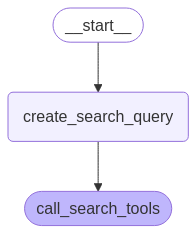

In [6]:
# Internet Searcher Graph

class SearchGraphState(TypedDict):
    """State for the Research Worker agent."""
    topic: str
    of_section: str
    search_tools_to_call: list
    search_queries_already_used: Annotated[list, operator.add]
    search_results: Annotated[list, operator.add]


class SearchGraphOutputState(TypedDict):
    """State for the Research Worker agent."""
    search_queries_already_used: list[str]
    search_results: list[str]

    
    
def create_search_query(state: SearchGraphState):
    """Create a search query for the topic."""
    out = llm_search_with_tools.invoke(
        [
            SystemMessage(content="You are a research assistant. You will be given a topic. Create a query that is helpful in searching the internet and will fetch meaningful information that helpful in writing. You can use the following tools to search the internet: Wikipedia, Tavily, Arxiv. Use the best tool to do search."),
            HumanMessage(content=f"{state['topic']} in {state['of_section']}"),
        ]
    )
    return {
        "search_tools_to_call": out.tool_calls
    }

def call_search_tools(state: SearchGraphState):
    tool_calls = state["search_tools_to_call"]
    print(f"\n\nFor Section : {state['of_section']} For topic : {state['topic']} the tool calls are :\n")
    for tool_call in tool_calls:
        print(f"Tool Name : {tool_call['name']} | Tool Args : {tool_call['args']['__arg1']}")
    print("\n\n")
    
    search_results = []
    new_search_queries = set()
    for tool_call in tool_calls:
        if tool_call["name"] == "search_wikipedia":
            if tool_call["args"] in state["search_queries_already_used"]:
                continue
            else:
                new_search_queries.add(tool_call["args"]["__arg1"])
                search_results_from_wikipedia = search_wikipedia.invoke(tool_call["args"])
                if len(search_results_from_wikipedia) > 0:
                    search_results.extend(search_results_from_wikipedia)
            
        elif tool_call["name"] == "search_tavily":
            if tool_call["args"] in state["search_queries_already_used"]:
                continue
            else:
                new_search_queries.add(tool_call["args"]["__arg1"])
                search_results_from_tavily = search_tavily.invoke(tool_call["args"])
                if len(search_results_from_tavily) > 0:
                    search_results.extend(search_results_from_tavily)
        elif tool_call["name"] == "search_arxiv":
            if tool_call["args"] in state["search_queries_already_used"]:
                continue
            else:
                new_search_queries.add(tool_call["args"]["__arg1"])
                search_results_from_arxiv = search_arxiv.invoke(tool_call["args"])
                if len(search_results_from_arxiv) > 0:
                    search_results.extend(search_results_from_arxiv)
        elif tool_call["name"] == "search_google":
            if tool_call["args"] in state["search_queries_already_used"]:
                continue
            else:
                new_search_queries.add(tool_call["args"]["__arg1"])
                search_results_from_google = search_google.invoke(tool_call["args"])
                if len(search_results_from_google) > 0:
                    search_results.extend(search_results_from_google)
    
    print("tool calls done")
    return {
        "search_results": search_results,
        "search_queries_already_used": list(new_search_queries)
    }

search_graph_builder = StateGraph(SearchGraphState, output=SearchGraphOutputState)
search_graph_builder.add_node("create_search_query", create_search_query)
search_graph_builder.add_node("call_search_tools", call_search_tools)

search_graph_builder.add_edge(
    START, "create_search_query"
)
search_graph_builder.add_edge(
    "create_search_query", "call_search_tools"
)
# search_graph_builder.add_edge("call_search_tools", END)
search_graph = search_graph_builder.compile()
display(Image(search_graph.get_graph().draw_mermaid_png()))

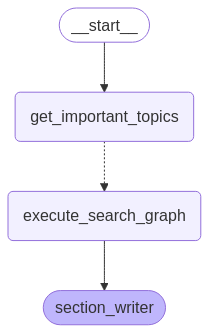

In [7]:
# Researcher Graph (uses the search graph to search the internet and then synthesizes the section)

class ResearcherState(TypedDict):
    """State for the Researcher agent."""
    section: str
    section_overview: str
    topics_of_section: list
    search_queries_already_used : Annotated[list, operator.add]
    compiled_sections: Annotated[list, operator.add]
    search_results: Annotated[list, operator.add]
    combined_written_sections = str

class ResearcherOutputState(TypedDict):
    """Output State for the Researcher agent."""
    search_queries_already_used : list[str]
    compiled_sections: list[WrittenSection]
    search_results: list[dict]


def get_important_topics(state: ResearcherState):
    """Get important topics from the research worker."""
    out = topic_identifying_llm.invoke(
        [
            SystemMessage(content="Given a section title and overview. Identify the topics which will be helpful to search the internet to better understanf the section. The topics must be less than 3 and must be relevant to the section."),
            HumanMessage(content=f"Section: {state['section']}\nSection Overview: {state['section_overview']}"),
        ]
    )
    print(f"\n\nThe topics identified for the Section {state['section']} are :\n {out.topics}\n\n")
    return {
        "topics_of_section": out.topics
    }

def assign_search_workers(state: ResearcherState):
    """Assign search workers to the topics."""
    print("\n\nAssigning search workers to the topics.\n\n")
    return [
        Send("execute_search_graph", {"topic": topic, "of_section": state["section"]}) for topic in state["topics_of_section"]
    ]


def section_writer(state: ResearcherState):
    """Synthesize the section."""
    print(f"\n\nWriting the section : {state['section']}.\n\n")
    out = section_writer_llm.invoke(
        [
            SystemMessage(content="You are a research assistant. You will be given a section title and overview. You will be given search results, filter them and select the useful ones to write the content of the section."),
            HumanMessage(content=f"Section: {state['section']}\nSection Overview: {state['section_overview']}\n  Search Results: {state['search_results']}"),
        ]
    )
    print(f"\n\nThe section {state['section']} is written.\n\n")
    return {
        "compiled_sections": [out]
    }

research_graph_builder = StateGraph(ResearcherState, output=ResearcherOutputState)

research_graph_builder.add_node("get_important_topics", get_important_topics)
research_graph_builder.add_node("execute_search_graph", search_graph_builder.compile())
research_graph_builder.add_node("section_writer", section_writer)

research_graph_builder.add_edge(START, "get_important_topics")
research_graph_builder.add_conditional_edges(
    "get_important_topics", assign_search_workers, ["execute_search_graph"]
)
research_graph_builder.add_edge("execute_search_graph", "section_writer")
# research_graph_builder.add_edge("section_writer", END)

# memory = MemorySaver()

research_graph = research_graph_builder.compile()
display(Image(research_graph.get_graph().draw_mermaid_png()))

In [8]:
class OrchestratorState(TypedDict):
    main_topic: str
    outline : str
    plan_in_text: str
    structured_plan: List[SectionPlan]
    feedback_on_report_plan: str
    compiled_sections : Annotated[list, operator.add]
    combined_written_sections: str
    search_results: Annotated[list, operator.add]
    search_queries_already_used : Annotated[list, operator.add]
    final_report : str

In [9]:
def generate_plan(state: OrchestratorState):
    """Generate an outline for the report."""
    print("Generating plan using deepseek")
    out = planner_llm.invoke(
        [
            SystemMessage(content="You are a research assistant. You will be given a main topic and an outline. You will generate a plan for a report. The plan must have sections and an overview for every section. Overview should cover the main topics and points of the section."),
            HumanMessage(content=f"Main Topic: {state['main_topic']}\n Outline: {state['outline']}"),
        ]
    )
    return {
        "plan_in_text": out
    }
    
def generate_plan_schema(state: OrchestratorState):
    """Extract the schema out of a plan mentioned in text."""
    print("Fitting plan into a schema")
    structured_plan = structured_planner.invoke(
        [
            SystemMessage(content="You are a research assistant. You will be given a plan for a report. You will extract the schema out of the plan."),
            HumanMessage(content=f"Plan: {state['plan_in_text']}"),
        ]
    )
    print("The structured plan is :\n:")
    for section in structured_plan.sections:
        print(f"Section: {section.title}\nOverview: {section.overview}\nWeb Search Required: {section.web_search_required}\n\n")
    return {
        "structured_plan": structured_plan.sections
    }
    
def web_search_required(state: OrchestratorState):
    """Check if web search is required for the sections."""
    print("\n\n Checking if web search is required for the sections.\n\n")
    web_search_required = False
    for section in state["structured_plan"]:
        if section.web_search_required == True:
            web_search_required = True
            return "do_web_search"
    return "no_web_search" 

def web_search_required_routing(state: OrchestratorState):
    """Assign initial section writing to the research worker."""
    print("\n\n Assigning writing workers to the sections which require web search.\n\n")
    web_search_required = False
    for section in state["structured_plan"]:
        if section.web_search_required == True:
            return "web_search_required"
    return "no_web_search_required"

def assign_web_search_writing_workers(state: OrchestratorState):
    """Assign search workers to the topics."""
    print("\n\n Assigning writing workers to the sections which require web search.\n\n")
    return [
        Send("write_sections_with_search", {"section": section.title, "section_overview": section.overview, "search_results": state["search_results"]})
        for section in state["structured_plan"]
        if section.web_search_required == True
    ]

def combine_written_sections(state: OrchestratorState):
    """Combine the written sections."""
    print("\n\n Combining the already written sections.\n\n")
    web_searched_written_section_info = ""
    for section in state["compiled_sections"]:
        web_searched_written_section_info += f"Section: {section.title}\nContent: {section.content}\nSources: {section.sources}\n\n"
    return {
        "combined_written_sections": web_searched_written_section_info
    }
    

def assign_no_web_search_writing_workers(state: OrchestratorState):
    """Assign search workers to the topics."""
    print("\n\n Assigning writing workers to the sections which do not require web search.\n\n")
    return [
        Send("write_sections_without_search", {"section": section.title, "section_overview": section.overview, "combined_written_sections": state["combined_written_sections"], "search_results": state["search_results"]})
        for section in state["structured_plan"]
        if section.web_search_required == False
    ]

def write_sections_without_search(state: ResearcherState):
    """Write the remaining sections which do not require web search."""
    print("\n\n Writing the sections which do not require web search.\n\n")  
    web_searched_written_section_info = state["combined_written_sections"]  
    out = section_writer_llm.invoke(
        [
            SystemMessage(content="You are a research assistant. You will be given a section title and overview and already written sections to write the content of this section."),
            HumanMessage(content=f"Section: {state['section']}\nSection Overview: {state['section_overview']}\n  Written Sections : {web_searched_written_section_info}"),
        ]
    )
    return {
        "compiled_sections": [out]
    }


def write_final_report(state: OrchestratorState):
    """Write the final report."""
    print("\n\n Writing the final report.\n\n")
    final_report = ""
    for section in state["compiled_sections"]:
        final_report += f"Section: {section.title}\nContent: {section.content}\nSources: {section.sources}\n\n"
    
    return {
        "final_report": final_report
    }

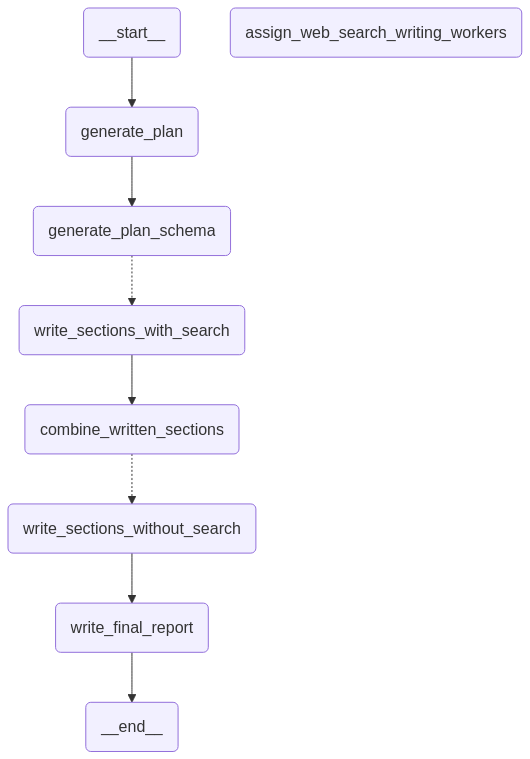

In [14]:
graph_builder = StateGraph(OrchestratorState)
graph_builder.add_node("generate_plan", generate_plan)
graph_builder.add_node("generate_plan_schema", generate_plan_schema)
graph_builder.add_node("write_sections_with_search", research_graph_builder.compile())
graph_builder.add_node("assign_web_search_writing_workers", assign_web_search_writing_workers)
graph_builder.add_node("combine_written_sections", combine_written_sections)
graph_builder.add_node("write_sections_without_search", write_sections_without_search)
graph_builder.add_node("write_final_report", write_final_report)

graph_builder.add_edge(START, "generate_plan")
graph_builder.add_edge("generate_plan", "generate_plan_schema")
graph_builder.add_conditional_edges(
    "generate_plan_schema", assign_web_search_writing_workers, ["write_sections_with_search"]
)
# graph_builder.add_conditional_edges(
#     "generate_plan_schema", web_search_required_routing, {"web_search_required": "assign_web_search_writing_workers", "no_web_search_required": "combine_written_sections"}
# )
graph_builder.add_edge("write_sections_with_search", "combine_written_sections")
graph_builder.add_conditional_edges(
    "combine_written_sections", assign_no_web_search_writing_workers, ["write_sections_without_search"]
)

graph_builder.add_edge("write_sections_without_search", "write_final_report")
graph_builder.add_edge("write_final_report", END)


# memory = MemorySaver()\
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
# config = {"configurable": {"thread_id": "1"}}

# input_researcher_state = {
#     "section": "Introduction to Large Language Models",
#     "section_overview": "This section will cover the basics of large language models, their architecture, and their applications.",
# }

input_orchestrator_state = {
    "main_topic": "Best Business Schools in the America",
    "outline": "This report will cover the best business schools in the Americas. Mention comparison just about two schools and just their alumni network have only two sections one uses web search and one doesnt.",
}

out = graph.invoke(input_orchestrator_state) #, config=config)

Generating plan using deepseek
Fitting plan into a schema
The structured plan is :
:
Section: Introduction
Overview: This section will introduce the importance of business schools in the Americas and their role in shaping future business leaders. It will briefly explain the criteria for evaluating business schools, with a focus on alumni networks as a key factor. The purpose of the report will be to compare two business schools based on their alumni networks, using both web search and traditional methods.
Web Search Required: False


Section: Alumni Networks: A Web Search Perspective
Overview: This section will explore the alumni networks of two top business schools in the Americas using web search. It will analyze the size, reach, and influence of their alumni networks by examining online resources such as LinkedIn, alumni websites, and news articles. The comparison will highlight how these networks contribute to the schools' reputations and career opportunities for graduates.
Web Sea

In [18]:
print(out["final_report"])

Section: Alumni Networks: A Web Search Perspective
Content: This section compares the alumni networks of two prominent business schools in the Americas using publicly available online resources.  While a comprehensive quantitative analysis is beyond the scope of a web search, we can qualitatively assess the size, reach, and influence of these networks.  Many sources indicate that Harvard Business School and Wharton School at the University of Pennsylvania consistently rank among schools with the largest and most influential alumni networks.  These networks are often cited as significant contributors to the schools' reputations and the career success of their graduates.  Further research using dedicated alumni databases or surveys would be needed for a more precise comparison.  However, a simple web search reveals the extensive online presence of these schools' alumni communities, including dedicated alumni websites, active LinkedIn groups, and frequent mentions in news articles about b

In [21]:
o = search_graph.invoke(
    {"topic": "Stanford Graduate School of Business alumni network", "of_section": "Alumni Networks For topic", "search_queries_already_used": []}
)
o



For Section : Alumni Networks For topic For topic : Stanford Graduate School of Business alumni network the tool calls are :

Tool Name : search_wikipedia | Tool Args : Stanford Graduate School of Business alumni network
Tool Name : search_tavily | Tool Args : Stanford Graduate School of Business alumni network
Tool Name : search_google | Tool Args : Stanford Graduate School of Business alumni network



tool calls done


{'search_queries_already_used': ['Stanford Graduate School of Business alumni network'],
 'search_results': [{'search_query': 'Stanford Graduate School of Business alumni network',
   'title': 'Stanford Graduate School of Business',
   'source': 'https://en.wikipedia.org/wiki/Stanford_Graduate_School_of_Business',
   'content': 'The Stanford Graduate School of Business  is the graduate business school of Stanford University, a private research university in Stanford, California. Stanford GSB is a member of the M7, an informal network of business schools regarded as among the most prestigious in the United States. For several years it has been the most selective business school in the United States, admitting only about 6% of applicants. Stanford GSB offers a general management Master of Business Administration (MBA) degree, the MSx Program (MS in Management for mid-career executives), Stanford LEAD Online Business Program and a PhD program, along with joint degrees with other schools a

In [1]:
input_researcher_state = {
    "section": "Alumni Networks",
    "section_overview": "This section compares the alumni networks of Harvard Business School and Stanford Graduate School of Business. It includes subsections for each school, detailing the size, reach, and influence of their networks, notable alumni, and the benefits these networks provide to current students.",
}

re_out = research_graph.invoke(input_researcher_state, config=config)

NameError: name 'research_graph' is not defined

{}